In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [14]:
day = cv2.imread("day.jpg")
generated = cv2.imread("image.png")

if day is None or generated is None:
    raise FileNotFoundError("Where is files?")

# Resize if needed
if day.shape != generated.shape:
    generated = cv2.resize(generated, (day.shape[1], day.shape[0]))


day_rgb = cv2.cvtColor(day, cv2.COLOR_BGR2RGB)
generated_rgb = cv2.cvtColor(generated, cv2.COLOR_BGR2RGB)

In [4]:
def compute_channel_mse(img1, img2):
    mse_r = np.mean((img1[:,:,0] - img2[:,:,0]) ** 2)
    mse_g = np.mean((img1[:,:,1] - img2[:,:,1]) ** 2)
    mse_b = np.mean((img1[:,:,2] - img2[:,:,2]) ** 2)
    
    mse_overall = (mse_r + mse_g + mse_b) / 3
    return mse_r, mse_g, mse_b, mse_overall

In [15]:
mse_r, mse_g, mse_b, mse_total = compute_channel_mse(generated_rgb, day_rgb)

print("\nPixel-wise MSE (BEFORE Matching):")
print(f"MSE Red:   {mse_r:.2f}")
print(f"MSE Green: {mse_g:.2f}")
print(f"MSE Blue:  {mse_b:.2f}")
print(f"Overall MSE: {mse_total:.2f}")


Pixel-wise MSE (BEFORE Matching):
MSE Red:   106.80
MSE Green: 105.71
MSE Blue:  105.84
Overall MSE: 106.12


In [21]:
def show_histograms(img1, img2, label2):
    colors = ['r', 'g', 'b']
    channel_names = ['Red', 'Green', 'Blue']
    
    plt.figure(figsize=(12, 8))
    
    for i in range(3):
        plt.subplot(3, 1, i+1)
        plt.hist(img1[:,:,i].ravel(), bins=256, alpha=0.5,
                 color=colors[i], label='Day')
        plt.hist(img2[:,:,i].ravel(), bins=256,
                 histtype='step', linewidth=2,
                 color=colors[i], label=label2)
        
        plt.title(f'{channel_names[i]} Channel Histogram')
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
        plt.legend()
    
    plt.tight_layout()
    plt.show()

Showing ORIGINAL histograms...


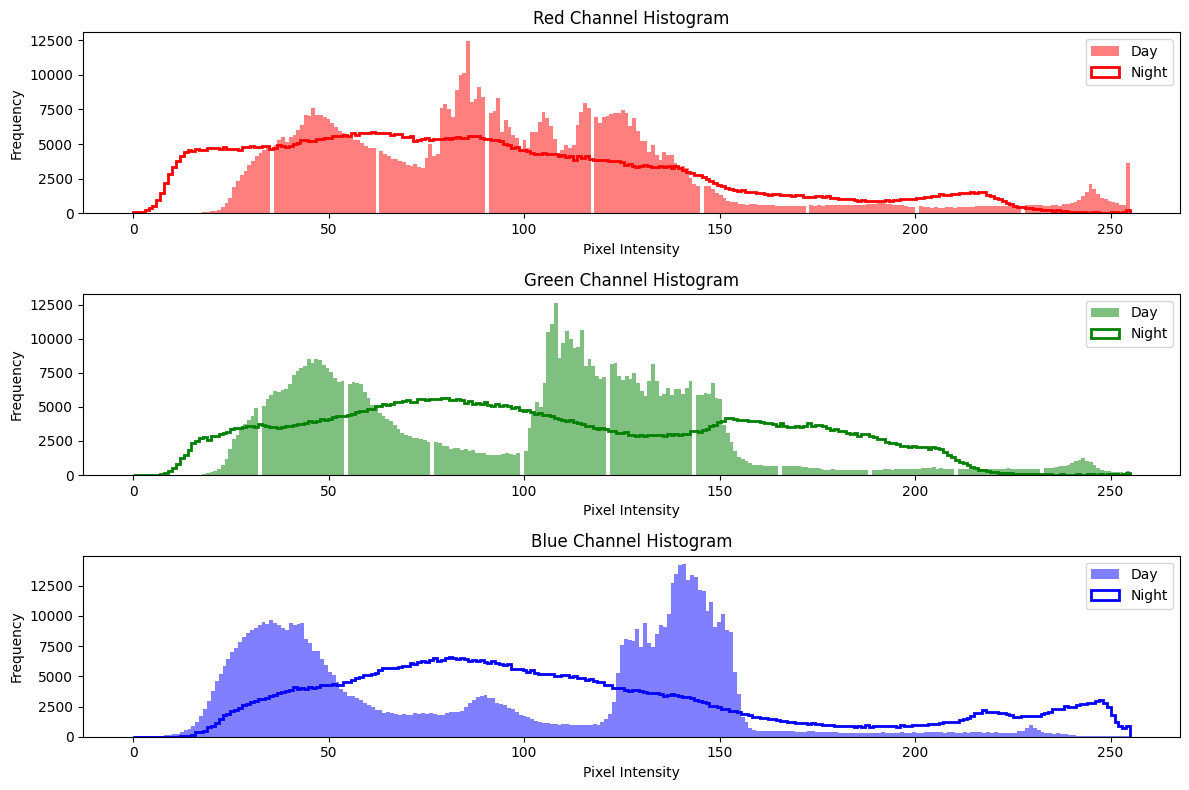


Pixel-wise MSE (BEFORE Matching):
MSE Red:   106.80
MSE Green: 105.71
MSE Blue:  105.84
Overall MSE: 106.12


In [22]:
print("Showing ORIGINAL histograms...")
show_histograms(day_rgb, generated_rgb, "Night")

mse_r, mse_g, mse_b, mse_total = compute_channel_mse(generated_rgb, day_rgb)

print("\nPixel-wise MSE (BEFORE Matching):")
print(f"MSE Red:   {mse_r:.2f}")
print(f"MSE Green: {mse_g:.2f}")
print(f"MSE Blue:  {mse_b:.2f}")
print(f"Overall MSE: {mse_total:.2f}")

In [24]:
def histogram_match(source, template):
    oldshape = source.shape
    source = source.ravel()
    template = template.ravel()

    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True, return_counts=True)
    t_values, t_counts = np.unique(template, return_counts=True)

    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]

    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]

    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

In [28]:
def histogram_match_3d(source, template, bins=32):
    """
    Match 3D color histogram of source to template.
    Preserves color relationships better than per-channel matching.
    """
    from scipy.interpolate import RegularGridInterpolator
    
    # Reshape to list of RGB values
    s_pixels = source.reshape(-1, 3)
    t_pixels = template.reshape(-1, 3)
    
    # Compute 3D histograms
    s_hist, edges = np.histogramdd(s_pixels, bins=bins, density=True)
    t_hist, _ = np.histogramdd(t_pixels, bins=edges, density=True)
    
    # Compute 3D CDFs
    s_cdf = np.cumsum(s_hist.ravel()) / s_hist.sum()
    t_cdf = np.cumsum(t_hist.ravel()) / t_hist.sum()
    
    # Create mapping in 3D space
    mapping = np.zeros_like(s_hist.ravel())
    for i, s_val in enumerate(s_cdf):
        mapping[i] = np.argmin(np.abs(t_cdf - s_val))
    
    mapping = mapping.reshape(s_hist.shape)
    
    # Create interpolation function for mapping
    points = [np.linspace(0, 1, bins) for _ in range(3)]
    interpolator = RegularGridInterpolator(points, mapping, 
                                          bounds_error=False, fill_value=None)
    
    # Map each pixel
    s_norm = s_pixels / 255.0  # Normalize to [0,1]
    mapped_indices = interpolator(s_norm)
    
    # Convert mapped indices back to RGB values
    result = np.zeros_like(s_pixels)
    for i in range(3):
        bin_width = 1.0 / bins
        result[:, i] = (mapped_indices[..., i] * bin_width + bin_width/2) * 255
    
    return result.reshape(source.shape)

In [31]:
matched = np.zeros_like(generated_rgb)
histogram_match_3d(generated_rgb, day_rgb)


array([[[ 90, 122, 186],
        [ 90, 122, 186],
        [ 90, 122, 186],
        ...,
        [ 90, 122, 186],
        [ 90, 122, 186],
        [ 90, 122, 186]],

       [[ 90, 122, 186],
        [ 90, 122, 186],
        [ 90, 122, 186],
        ...,
        [ 90, 122, 186],
        [ 90, 122, 186],
        [ 90, 122, 186]],

       [[ 90, 122, 186],
        [ 90, 122, 186],
        [ 90, 122, 186],
        ...,
        [ 90, 122, 186],
        [ 90, 122, 186],
        [ 90, 122, 186]],

       ...,

       [[ 90, 122, 186],
        [ 90, 122, 186],
        [ 90, 122, 186],
        ...,
        [ 90, 122, 186],
        [ 90, 122, 186],
        [ 90, 122, 186]],

       [[ 90, 122, 186],
        [ 90, 122, 186],
        [ 90, 122, 186],
        ...,
        [ 90, 122, 186],
        [ 90, 122, 186],
        [ 90, 122, 186]],

       [[ 90, 122, 186],
        [ 90, 122, 186],
        [ 90, 122, 186],
        ...,
        [ 90, 122, 186],
        [ 90, 122, 186],
        [ 90, 122, 186]]

In [34]:
matched = np.zeros_like(generated_rgb)
for i in range(3):
    matched[:,:,i] = histogram_match(generated_rgb[:,:,i], day_rgb[:,:,i])

matched = matched.astype(np.uint8)


Showing MATCHED histograms...


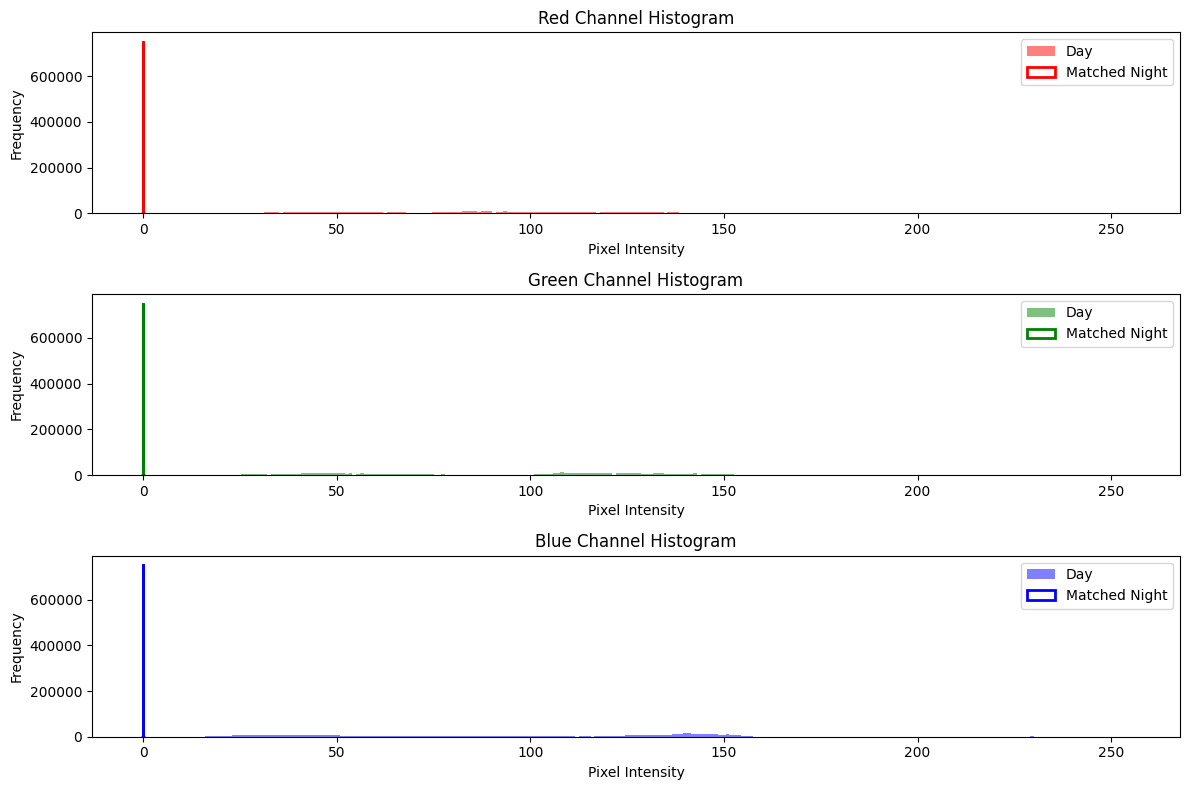


Pixel-wise MSE (AFTER Matching):
MSE Red:   106.33
MSE Green: 105.03
MSE Blue:  104.88
Overall MSE: 105.41


In [32]:
print("\nShowing MATCHED histograms...")
show_histograms(day_rgb, matched, "Matched Night")

mse_r2, mse_g2, mse_b2, mse_total2 = compute_channel_mse(matched, day_rgb)

print("\nPixel-wise MSE (AFTER Matching):")
print(f"MSE Red:   {mse_r2:.2f}")
print(f"MSE Green: {mse_g2:.2f}")
print(f"MSE Blue:  {mse_b2:.2f}")
print(f"Overall MSE: {mse_total2:.2f}")

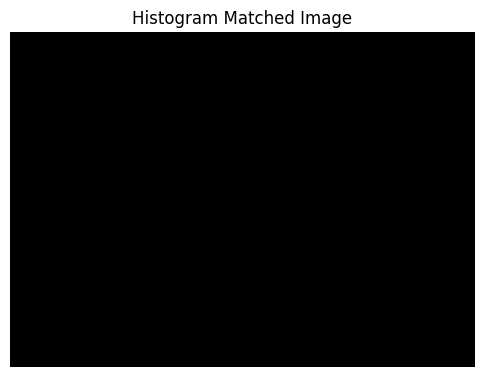

In [33]:
plt.figure(figsize=(6,6))
plt.imshow(matched)
plt.title("Histogram Matched Image")
plt.axis("off")
plt.show()